# Example: Filtering on a tripole grid

In this tutorial, we will use **Laplacians of varying complexity** to filter **tracer fields** on a global tripole grid ([Murray, 1996](https://www.sciencedirect.com/science/article/pii/S0021999196901369)). For example, **POP** and **MOM6** have configurations that use a global tripole grid.

In [1]:
import gcm_filters
import numpy as np
import xarray as xr

The following are the grid types that we have so far implemented in `gcm-filters`:

In [2]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_AREA_WEIGHTED: 2>,
 <GridType.REGULAR_WITH_LAND: 3>,
 <GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>,
 <GridType.IRREGULAR_WITH_LAND: 5>,
 <GridType.MOM5U: 6>,
 <GridType.MOM5T: 7>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED: 8>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 9>,
 <GridType.VECTOR_C_GRID: 10>]

For each of these grid types, we have implemented a Laplacian that operates on the respective grid type. In this notebook, we will apply 4 Laplacians to filter **tracer fields on a global tripole grid**. 

| Laplacian | simple fixed factor  | fixed filter length scale|
| ----------- | ----------- | --------------|
| Ignores tripolar exchanges  | `REGULAR_WITH_LAND_AREA_WEIGHTED`       | `IRREGULAR_WITH_LAND` |
| Handles tripolar exchanges  | `TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED`        | `TRIPOLAR_POP_WITH_LAND` |

As shown in the table, the categories in which the 4 Laplacians differ are:
* **complexity** (rows)
* **filter type** they can be used for (columns)

For details on different filter types, see [this tutorial](https://gcm-filters.readthedocs.io/en/latest/tutorial_filter_types.html).
In short:
* A filter with **fixed factor**, e.g., `factor = 10`, attempts to remove scales smaller than 10 times the local grid scale. 
* A filter with **fixed filter length scale**, e.g., `filter_scale = 100 km`, attempts to remove scales smaller than 100km. 

**Side note:** The Laplacians in the right column can also be used for fixed factor filtering (less ad hoc than the simple fixed factor filters), anisotropic filtering, and for filtering with spatially-varying filter scale, through the use of spatially-varying `kappa`'s, see the [Filter Theory](https://gcm-filters.readthedocs.io/en/latest/theory.html) and [this tutorial](https://gcm-filters.readthedocs.io/en/latest/tutorial_filter_types.html). In summary, the Laplacians in the right column are more flexible than the Laplacians in the left column - but also more expensive. In this notebook, we use the Laplacians in the right column only for filtering with fixed filter scale.

## Global POP data

First, we are going to work with the 0.1 degree nominal resolution POP tripole grid ([Smith et al., 2010](https://www.cesm.ucar.edu/models/cesm1.0/pop2/doc/sci/POPRefManual.pdf)). The grid variables are stored in the following dataset, which we pull from figshare.

In [3]:
import pooch

fname = pooch.retrieve(
    url="doi:10.6084/m9.figshare.14607684.v1/POP_SST.nc",
    known_hash="md5:0023da8e42dcd2141805e553a023078c",
)
ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 1, z_t: 62)
Coordinates:
  * time     (time) object 0033-11-27 00:00:00
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 537500.0 562499.06 587499.06
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT      (nlat, nlon) float64 ...
    TAREA    (nlat, nlon) float64 ...
    HTN      (nlat, nlon) float64 ...
    HTE      (nlat, nlon) float64 ...
    HUS      (nlat, nlon) float64 ...
    HUW      (nlat, nlon) float64 ...
    SST      (time, nlat, nlon) float32 ...
Attributes:
    title:           g.e01.GIAF.T62_t12.003
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 46405 2013-04-26 05:24:34Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2014-07-19 at 17:28:03.3
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    9618241
    tavg_sum:        431999.9999999717
    tavg_sum_qflux:  432000.00000000006

### Preparing the POP grid information

All Laplacians listed in our table need a `wet_mask`. This is a mask that is 1 in ocean T-cells, and 0 in land T-cells. Since we only want to filter temperature in the uppermost level, we only need a 2D `wet_mask`.

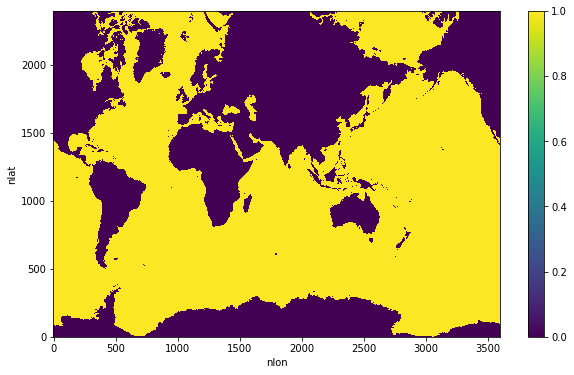

In [4]:
wet_mask = xr.where(ds['KMT']>0, 1, 0)
wet_mask.plot(figsize=(10,6), cbar_kwargs={'label': ''});

Let's start by creating the grid information for the `TRIPOLAR_POP_WITH_LAND` Laplacian. The required grid variables are directly available from POP's model diagnostics:

In [5]:
dxe = ds.HUS / 100  # x-spacing centered at eastern T-cell edge in m
dye = ds.HTE / 100  # y-spacing centered at eastern T-cell edge in m
dxn = ds.HTN / 100  # x-spacing centered at northern T-cell edge in m
dyn = ds.HUW / 100  # y-spacing centered at northern T-cell edge in m
area = ds.TAREA / 10000  # T-cell area in m2

The `IRREGULAR_WITH_LAND` Laplacian was coded for general curvilinear grids and uses a south-west convention (rather than a north-east convention). In other words, it needs grid length information about the western and southern cell edges: `dxw`, `dyw`, `dxs`, `dys`.

In [6]:
dxw = ds.HUS.roll(nlon=1, roll_coords=False) / 100  # x-spacing centered at western T-cell edge in m
dyw = ds.HTE.roll(nlon=1, roll_coords=False) / 100  # y-spacing centered at western T-cell edge in m
dxs = ds.HTN.roll(nlat=1, roll_coords=False) / 100  # x-spacing centered at southern T-cell edge in m
dys = ds.HUW.roll(nlat=1, roll_coords=False) / 100  # y-spacing centered at southern T-cell edge in m

Finally, the filters with fixed filter length scale will have to know what the minimum grid spacing is in our model.

In [7]:
dx_min_POP = min(dxe.where(wet_mask).min(), dye.where(wet_mask).min(), dxn.where(wet_mask).min(), dyn.where(wet_mask).min())
dx_min_POP = dx_min_POP.values
dx_min_POP

array(2245.78304344)

### Field to be filtered

Usually, fields that we would want to filter on a tripole grid are fields from model output (from a model with native tripole grid), e.g., temperature, salinity, kinetic energy. Here, we instead filter a very simple field: the difference of two **delta functions**, $\delta = \delta_1 - \delta_2$, where $\delta_1$ and $\delta_2$ have **mass close to the northern boundary fold** of the logical POP tripole grid. This choice will make the difference between the different Laplacians in our table above extra clear.

In [8]:
delta1 = 0 * xr.ones_like(ds.nlat * ds.nlon)  # initialize 2D field with zeros
delta2 = 0 * xr.ones_like(ds.nlat * ds.nlon)  # initialize 2D field with zeros
delta1[-20:-1, 750:770] = 1  # deploy mass in the uppermost 20 rows; width: 20 columns
delta2[-20:-1, 2600:2620] = 1  # deploy mass in the uppermost 20 rows; width: 20 columns
delta = delta1 - delta2
delta = delta.where(wet_mask)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

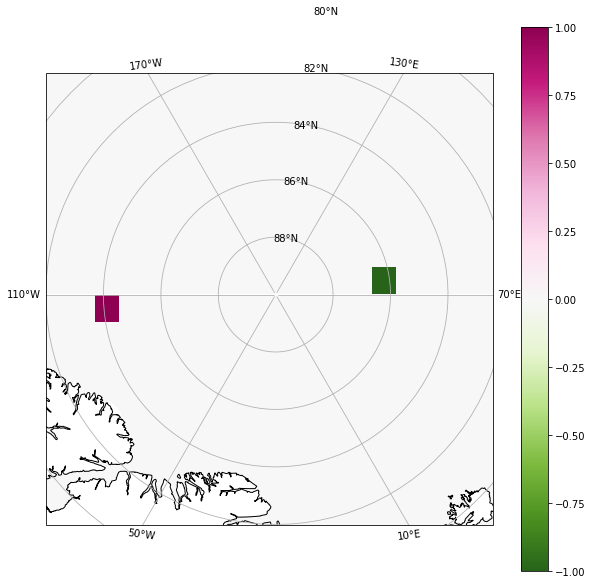

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=-20.0)})
delta.plot(ax=ax, x='TLONG', y='TLAT', cmap='PiYG_r', transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-170,180,60))
gl.ylocator = mticker.FixedLocator(np.arange(80,90,2))
ax.set_extent([-20, 340, 82, 90], ccrs.PlateCarree())

In the model, there are exchanges across the longitude line from **110$^\circ$W to 70$^\circ$E**. The **Laplacians that handle tripolar exchanges** (second row in table above) will diffuse the two delta functions **across** this longitude line--**the tripole seam**.

### Simple fixed factor filters

First, we create the two filters with **fixed factor** (left column in table above). In both cases, we choose a **fixed factor of 50** and a **Gaussian filter shape**.

In [11]:
specs = {
    'filter_scale': 50,
    'dx_min': 1,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN
}

In [12]:
filter_regular_with_land = gcm_filters.Filter(
    **specs,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area':area, 'wet_mask': wet_mask}
)
filter_regular_with_land

Filter(filter_scale=50, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=56, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

In [13]:
filter_tripolar_regular_with_land = gcm_filters.Filter(
    **specs,
    grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area, 'wet_mask': wet_mask}
)
filter_tripolar_regular_with_land

Filter(filter_scale=50, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=56, grid_type=<GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED: 8>)

In [14]:
%time delta_filtered_regular_with_land = filter_regular_with_land.apply(delta, dims=['nlat', 'nlon'])
%time delta_filtered_tripolar_regular_with_land = filter_tripolar_regular_with_land.apply(delta, dims=['nlat', 'nlon']) 

CPU times: user 15 s, sys: 9.4 s, total: 24.4 s
Wall time: 24.4 s
CPU times: user 16.2 s, sys: 9.93 s, total: 26.2 s
Wall time: 26.3 s


Filtering with the second filter took a touch longer than with the first filter because the second filter is of increased complexity: it handles the tripolar boundary condition correctly, whereas the first filter does not. This is shown in the figure below.

[Text(0.5, 1.0, 'filtered with TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED Laplacian')]

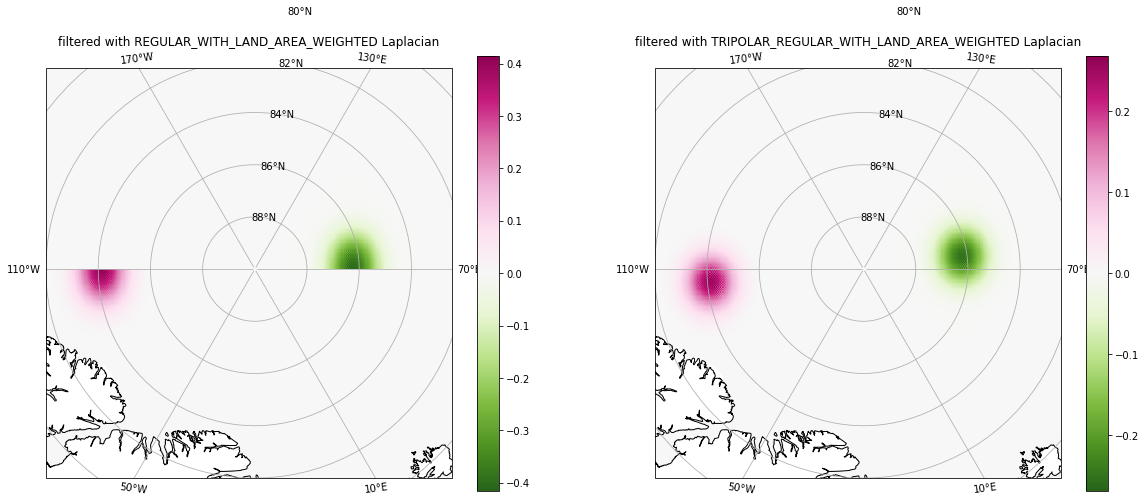

In [15]:
fig, axs = plt.subplots(1,2, figsize=(20,8), subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=-20.0)})
delta_filtered_regular_with_land.plot(ax=axs[0], x='TLONG', y='TLAT', cmap='PiYG_r', transform=ccrs.PlateCarree())
delta_filtered_tripolar_regular_with_land.plot(ax=axs[1], x='TLONG', y='TLAT', cmap='PiYG_r', transform=ccrs.PlateCarree())
for ax in axs.flatten():
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator(np.arange(-170,180,60))
    gl.ylocator = mticker.FixedLocator(np.arange(80,90,2))
    ax.set_extent([-20, 340, 82, 90], ccrs.PlateCarree())
axs[0].set(title='filtered with REGULAR_WITH_LAND_AREA_WEIGHTED Laplacian')
axs[1].set(title='filtered with TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED Laplacian')

* **Left panel**: The `REGULAR_WITH_LAND_AREA_WEIGHTED` Laplacian **does not allow** exchanges across the tripole seam.
* **Right panel**: The `TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED` Laplacian **allows** exchanges across the tripole seam.

### Filters with fixed filter length scale

The next two filters are for filtering with **fixed length scale** (right column in table above). For both filters, we pick a filter length scale of **200 km**.

In [16]:
specs = {
    'filter_scale': 200000,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN,
    'dx_min': dx_min_POP
}

In [17]:
filter_irregular_with_land = gcm_filters.Filter(
    **specs,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': xr.ones_like(dxw), 'kappa_s': xr.ones_like(dxs)
    }
)
filter_irregular_with_land

<string>:10: UserWarning: Filter scale much larger than grid scale -> numerical instability possible. More information on numerical instability can be found at https://gcm-filters.readthedocs.io/en/latest/theory.html.


Filter(filter_scale=200000, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=98, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [18]:
filter_tripolar_pop_with_land = gcm_filters.Filter(
    **specs,
    grid_type=gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxe': dxe, 'dye': dye, 'dxn': dxn, 'dyn': dyn, 'tarea': area
    }
)
filter_tripolar_pop_with_land

<string>:10: UserWarning: Filter scale much larger than grid scale -> numerical instability possible. More information on numerical instability can be found at https://gcm-filters.readthedocs.io/en/latest/theory.html.


Filter(filter_scale=200000, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=98, grid_type=<GridType.TRIPOLAR_POP_WITH_LAND: 9>)

In [19]:
%time delta_filtered_irregular_with_land = filter_irregular_with_land.apply(delta, dims=['nlat', 'nlon'])
%time delta_filtered_tripolar_pop_with_land = filter_tripolar_pop_with_land.apply(delta, dims=['nlat', 'nlon'])

CPU times: user 32.2 s, sys: 17.4 s, total: 49.6 s
Wall time: 49.6 s
CPU times: user 33.9 s, sys: 17.2 s, total: 51.1 s
Wall time: 51.3 s


Again, filtering with the second filter took a touch longer than with the first filter (but not too much longer), due to the correct handling of the tripolar boundary exchanges.

[Text(0.5, 1.0, 'filtered with TRIPOLAR_POP_WITH_LAND Laplacian')]

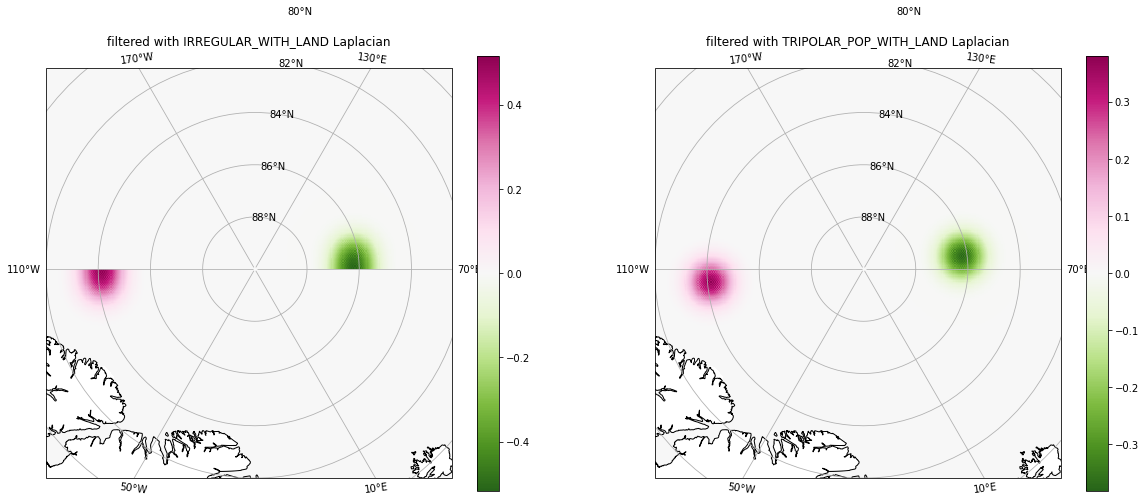

In [20]:
fig, axs = plt.subplots(1,2, figsize=(20,8), subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=-20.0)})
delta_filtered_irregular_with_land.plot(ax=axs[0], x='TLONG', y='TLAT', cmap='PiYG_r', transform=ccrs.PlateCarree())
delta_filtered_tripolar_pop_with_land.plot(ax=axs[1], x='TLONG', y='TLAT', cmap='PiYG_r', transform=ccrs.PlateCarree())
for ax in axs.flatten():
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator(np.arange(-170,180,60))
    gl.ylocator = mticker.FixedLocator(np.arange(80,90,2))
    ax.set_extent([-20, 340, 82, 90], ccrs.PlateCarree())
axs[0].set(title='filtered with IRREGULAR_WITH_LAND Laplacian')
axs[1].set(title='filtered with TRIPOLAR_POP_WITH_LAND Laplacian')

* **Left panel**: The `IRREGULAR_WITH_LAND` Laplacian **does not allow** exchanges across the tripole seam.
* **Right panel**: The `TRIPOLAR_POP_WITH_LAND` Laplacian **allows** exchanges across the tripole seam.

## Global MOM6 data

Next, we filter surface vorticity field from a $1/4^{\circ}$ global MOM6 simulation using the `REGULAR_WITH_LAND_AREA_WEIGHTED` and `TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED` Laplacians. We use these Laplacians for **simple fixed factor filtering by a factor of 10**.

In [21]:
fname = pooch.retrieve(
    url="doi:10.6084/m9.figshare.14575356.v1/Global_U_SSH.nc",
    known_hash="md5:f98b5f2d1f3ccef5685851519481b2da",
)
ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
    time          object ...
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    ssu           (yh, xq) float32 ...
    ssv           (yq, xh) float32 ...
    zos           (yh, xh) float32 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    deptho        (yh, xh) float32 ...
    dxCu          (yh, xq) float32 ...
    dxCv          (yq, xh) float32 ...
    dxt           (yh, xh) float32 ...
    dyCu          (yh, xq) float32 ...
    dyCv          (yq, xh) float32 ...
    dyt           (yh, xh) float32 ...
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolat_u      (yh, xq) float32 ...
    geolat_v      (yq, xh) float32 ...
    geolon        (yh, xh) float32 ...
    geolon_c      (yq, xq) float32 ...
    geolon_u      (yh, xq) float32 ...
    geolon_v      (yq, xh) float32 ...
    hfgeou        (yh, xh) float32 ...
    sftof         (yh, xh) float32 ...
    wet           (yh, xh) float32 ...
    wet_c         (yq, xq) float32 ...
    wet_u         (yh, xq) float32 ...
    wet_v         (yq, xh) float32 ...
    zeta          (yq, xq) float32 ...

In [22]:
ds2 = ds.astype(np.float64) # double precision to avoid numerical instability in gcm-filters algorithm
wet_mask = ds2['wet_c']
area = ds2['areacello_bu']

In [23]:
factor = 10
dx_min = 1
filter_shape = gcm_filters.FilterShape.GAUSSIAN

filter_regular_with_land = gcm_filters.Filter(
    filter_scale=factor,
    dx_min=dx_min,
    filter_shape=filter_shape,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area, 'wet_mask': wet_mask}
)
filter_regular_with_land

filter_tripolar_regular_with_land = gcm_filters.Filter(
    filter_scale=factor,
    dx_min=1,
    filter_shape=filter_shape,
    grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area, 'wet_mask': wet_mask}
)
filter_tripolar_regular_with_land

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED: 8>)

In [24]:
%time zeta_filtered_regular_with_land = filter_regular_with_land.apply(ds2['zeta'], dims=['yq', 'xq'])
%time zeta_filtered_tripolar_regular_with_land = filter_tripolar_regular_with_land.apply(ds2['zeta'], dims=['yq', 'xq'])

CPU times: user 564 ms, sys: 48.7 ms, total: 613 ms
Wall time: 616 ms
CPU times: user 596 ms, sys: 99.8 ms, total: 696 ms
Wall time: 698 ms


In [25]:
# Function for plotting

def plot_map(ax, da, vmin=-999, vmax=999,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    cb.ax.tick_params(labelsize=12)

    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    p.axes.set_extent([-300, 60, 75, 90], ccrs.PlateCarree())
    
    _ = plt.title(title, fontsize=14)
    return fig

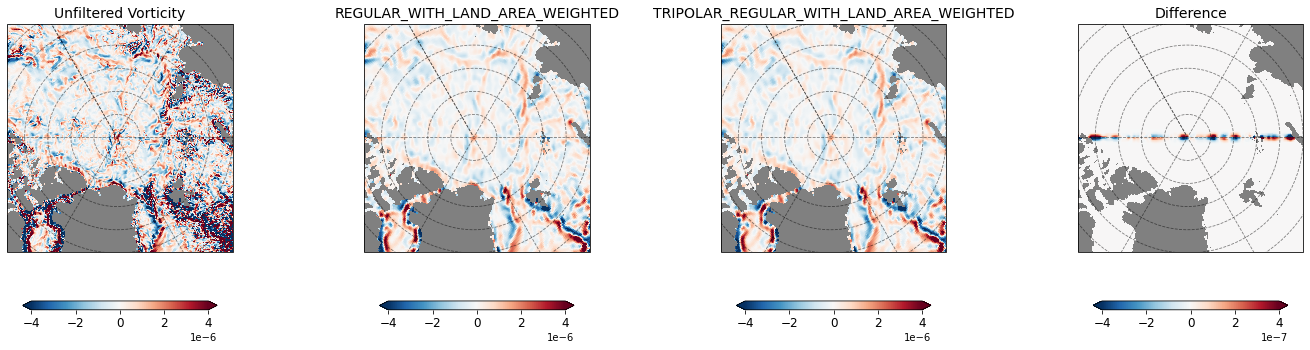

In [26]:
zeta_reg = zeta_filtered_regular_with_land.assign_coords({'geolat_c': ds2['geolat_c'], 'geolon_c': ds2['geolon_c']})
zeta_tripole = zeta_filtered_tripolar_regular_with_land.assign_coords({'geolat_c': ds2['geolat_c'], 'geolon_c': ds2['geolon_c']})
zeta = ds2['zeta'].assign_coords({'geolat_c': ds2['geolat_c'], 'geolon_c': ds2['geolon_c']})

grid1 = plt.GridSpec(1, 4, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[25,6])

max_z = 0.4e-5
subplot_kws=dict(projection=ccrs.NorthPolarStereo(central_longitude=-30.0),facecolor='grey')

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.NorthPolarStereo(central_longitude=-30.0),facecolor='grey')
_ = plot_map(ax, zeta, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'Unfiltered Vorticity')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.NorthPolarStereo(central_longitude=-30.0),facecolor='grey')
_ = plot_map(ax, zeta_reg, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'REGULAR_WITH_LAND_AREA_WEIGHTED')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.NorthPolarStereo(central_longitude=-30.0),facecolor='grey')
_ = plot_map(ax, zeta_tripole, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.NorthPolarStereo(central_longitude=-30.0),facecolor='grey')
_ = plot_map(ax, zeta_tripole - zeta_reg, vmin=-max_z*0.1, vmax=max_z*0.1, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'Difference')

The two methods give different answers along the horizontal line (passing through the pole), which is the longitudinal boundary of the model grid. This is because the `TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED` Laplacian correctly handles tripolar exchanges, but the `REGULAR_WITH_LAND_AREA_WEIGHTED` Laplacian does not.